In [1]:
import openslide
from openslide import open_slide
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

### Open WSI Image File

In [10]:
ndpi_filename = rf'OTS-25-25256 - 2025-08-01 13.59.31_duodenum'

ndpi_file_root = rf'C:\Users\durrlab-asong\Downloads'

wsi = open_slide(os.path.join(ndpi_file_root, f'{ndpi_filename}.ndpi'))

OpenSlideError: Can't validate JPEG for directory 0: Expected marker at 4294972193, found none

In [7]:
print(wsi.properties)

<_PropertyMap {'hamamatsu.AHEX[0]': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'hamamatsu.AHEX[0].fluorescence': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'hamamatsu.AHEX[0].ploidy': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'hamamatsu.AHEX[1]': '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', 'hamamatsu.AHEX[1].fluorescence': '0000000000000000000000000000000000000000000000

In [8]:
print(wsi.dimensions)
print(wsi.level_dimensions)

(172800, 112640)
((172800, 112640), (86400, 56320), (43200, 28160), (21600, 14080), (10800, 7040), (5400, 3520), (2700, 1760), (1350, 880))


### Show the Thumbnail of the WSI at smallest resolution

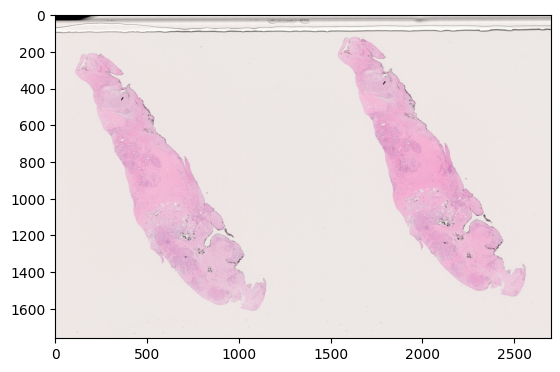

In [9]:
x_start = 0
y_start = 0
wsi_level = 6
level_wsi = wsi.read_region([x_start,y_start], level=wsi_level, size = [round(wsi.level_dimensions[wsi_level][0]), wsi.level_dimensions[wsi_level][1]])

plt.imshow(level_wsi)
level_wsi.save(os.path.join(ndpi_file_root, rf'{ndpi_filename}wsi_thumbnail_level{wsi_level}.png'), 'PNG')

### Select ROIs that we want Ground Truth from 
#### This GUI below allows us to select an ROI at the second lowest resolution (level 6), then rescales the resolution to the highest and saves the ROI

In [38]:
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
from PIL import Image, ImageTk
import numpy as np
# Function to open an image
def open_image():
    global img, downscaled_img, upscale_factor, canvas, img_tk
    # Open file dialog to select image
    file_path = filedialog.askopenfilename()
    if not file_path:
        return
    img = Image.open(file_path)
    upscale_factor = 2**6  # Define the upscale factor (you can modify this)
    # Downscale the image by the upscale factor
    downscaled_img = img.resize((img.width // upscale_factor, img.height // upscale_factor))
    # Convert to tkinter image for displaying on canvas
    img_tk = ImageTk.PhotoImage(img)
    # Update canvas size to match the original image
    canvas.config(width=img.width, height=img.height)
    # Display the full-size image on canvas
    canvas.create_image(0, 0, anchor="nw", image=img_tk)
    canvas.image = img_tk  # Keep a reference to avoid garbage collection
# Function to handle ROI selection
def select_roi(event):
    global start_x, start_y, end_x, end_y, canvas, downscaled_img
    # Record starting coordinates of the rectangle
    start_x, start_y = event.x, event.y
    # Create a rectangle on canvas to show the ROI selection
    canvas.create_rectangle(start_x, start_y, start_x, start_y, outline="red", width=2, tags="roi_rect")
# Function to update the rectangle dimensions as user drags the mouse
def update_roi(event):
    global start_x, start_y, canvas
    # Update the rectangle as user drags the mouse
    canvas.coords("roi_rect", start_x, start_y, event.x, event.y)
# Function to finalize the ROI selection, output the dimensions in the upscaled form, write to a .txt file, and display cropped image
def finalize_roi(event):
    global start_x, start_y, end_x, end_y, canvas, downscaled_img, img, upscale_factor
    # Get the final coordinates for the ROI
    end_x, end_y = event.x, event.y
    # Calculate the coordinates of the ROI in the original (upscaled) image
    roi_x1 = int(start_x * upscale_factor)
    roi_y1 = int(start_y * upscale_factor)
    roi_x2 = int(end_x * upscale_factor)
    roi_y2 = int(end_y * upscale_factor)
    # Calculate the dimensions of the ROI in the upscaled image
    upscaled_width = roi_x2 - roi_x1
    upscaled_height = roi_y2 - roi_y1
    # Display the ROI dimensions in the upscaled image
    print(f"Upscaled ROI dimensions: Width = {upscaled_width}, Height = {upscaled_height}")
    # Optionally, display these dimensions in a message box or on the GUI
    result_label.config(text=f"Upscaled ROI dimensions: {upscaled_width} x {upscaled_height}")
    # Ask for the save location and filename for the ROI coordinates
    save_path = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt")])
    if not save_path:
        return
    # Write the ROI coordinates to the specified .txt file
    with open(save_path, "w") as file:
        file.write(f"ROI coordinates in the upscaled image:\n")
        file.write(f"Top-left: ({roi_x1}, {roi_y1})\n")
        file.write(f"Bottom-right: ({roi_x2}, {roi_y2})\n")
        file.write(f"Width: {upscaled_width}\n")
        file.write(f"Height: {upscaled_height}\n")
    print(f"ROI coordinates written to '{save_path}'.")
    # Remove the rectangle after finalizing the selection
    canvas.delete("roi_rect")
    # Crop the image using the ROI coordinates
    cropped_img = img.crop((start_x, start_y, end_x, end_y))
    # Convert cropped image to tkinter image format
    cropped_img_tk = ImageTk.PhotoImage(cropped_img)
    # Create a new window to display the cropped image
    cropped_window = tk.Toplevel(root)
    cropped_window.title("Cropped Image")
    # Create a canvas to display the cropped image
    cropped_canvas = tk.Canvas(cropped_window, width=upscaled_width, height=upscaled_height)
    cropped_canvas.pack()
    # Display the cropped image on the canvas
    cropped_canvas.create_image(0, 0, anchor="nw", image=cropped_img_tk)
    cropped_canvas.image = cropped_img_tk  # Keep a reference to avoid garbage collection
# Setup the Tkinter window
root = tk.Tk()
root.title("Image ROI Selector")
# Create a canvas to display the full-size image
canvas = tk.Canvas(root, width=512, height=512)  # Default canvas size (adjusted later based on image)
canvas.pack()
# Label to display the result
result_label = tk.Label(root, text="Upscaled ROI dimensions: ")
result_label.pack()
# Add a button to load an image
load_button = tk.Button(root, text="Open Image", command=open_image)
load_button.pack()
# Add a label for instructions
instructions_label = tk.Label(root, text="Click and drag to select the ROI.\nRight-click to finalize.")
instructions_label.pack()
# Bind mouse events to select and finalize ROI
canvas.bind("<ButtonPress-1>", select_roi)  # Left-click to start selection
canvas.bind("<B1-Motion>", update_roi)  # Update the selection as user drags the mouse
canvas.bind("<ButtonRelease-3>", finalize_roi)  # Right-click to finalize the selection
# Run the Tkinter event loop
root.mainloop()

Upscaled ROI dimensions: Width = 3648, Height = 3456
ROI coordinates written to 'C:/Users/durrlab-asong/OneDrive - Johns Hopkins/MUSE-BIT/20250701_kidney_JH69436370/tumor/FFPE-HE/train_test_patches/figure_roi_1.txt'.


In [15]:
def load_roi(file_path):
    # Initialize variables to hold the extracted values
    roi_x1, roi_y1, roi_x2, roi_y2, width, height = None, None, None, None, None, None
    # Open the text file
    with open(file_path, "r") as file:
        # Read each line of the file
        lines = file.readlines()
        # Loop through lines to find and extract the relevant data
        for line in lines:
            if "Top-left" in line:
                # Extract the top-left coordinates
                roi_x1, roi_y1 = map(int, line.split(":")[1].strip()[1:-1].split(","))
            elif "Bottom-right" in line:
                # Extract the bottom-right coordinates
                roi_x2, roi_y2 = map(int, line.split(":")[1].strip()[1:-1].split(","))
            elif "Width" in line:
                # Extract the width
                width = int(line.split(":")[1].strip())
            elif "Height" in line:
                # Extract the height
                height = int(line.split(":")[1].strip())
    # Return the extracted values
    return roi_x1, roi_y1, roi_x2, roi_y2, width, height


Top-left: (35648, 81984)
Bottom-right: (39296, 85440)
Width: 3648
Height: 3456


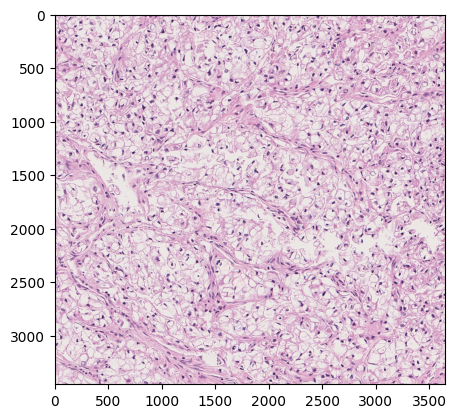

In [39]:
roi_name = 'figure_roi_1'
roi = roi_name +'.txt'
file_path = rf"C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\FFPE-HE\{roi}"  # Path to the ROI text file
roi_x1, roi_y1, roi_x2, roi_y2, width, height = load_roi(os.path.join(ndpi_file_root, 'train_test_patches', roi))
# Print the extracted values
print(f"Top-left: ({roi_x1}, {roi_y1})")
print(f"Bottom-right: ({roi_x2}, {roi_y2})")
print(f"Width: {width}")
print(f"Height: {height}")

example = wsi.read_region([roi_x1,roi_y1], 0, [width,height])
plt.imshow(example)

In [40]:

example.save(os.path.join(ndpi_file_root, rf'{ndpi_filename}wsi_thumbnail_level_{roi_name}.png'), 'PNG')

### Split into Patches and then save as .png images. 

#### This takes in a magnification rescaled image based on the BIT microscope image and Hamamatsu slide scanner, and then splits the image into n x n patches. 

In [13]:
def split_image_into_patches(image, patch_size, overlap, output_folder, handle="patch", extension = "png"):
    """
    Splits an image into n x n patches with overlap, and saves them to a folder.
    Only saves complete patches of the specified size.
    Args:
    - image: PIL image to split
    - patch_size: Size of the patches (e.g., (256, 256))
    - overlap: Overlap between patches (e.g., 50 for 50-pixel overlap)
    - output_folder: Folder to save the patches
    - handle: Prefix for the patch file name
    Returns:
    - None
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    # Convert the image to a NumPy array
    np_image = np.array(image)
    # Get the dimensions of the image
    height, width = np_image.shape[0], np_image.shape[1]
    # Calculate the step size (patch size minus overlap)
    step = patch_size[0] - overlap
    patch_number = 1  # Counter for patches
    # Iterate through the image and extract patches
    for y in range(0, height - patch_size[0] + 1, step):
        for x in range(0, width - patch_size[1] + 1, step):
            # Check if the patch is within the image boundaries
            if y + patch_size[0] <= height and x + patch_size[1] <= width:
                # Extract the patch
                patch = np_image[y:y + patch_size[0], x:x + patch_size[1]]
                # Convert the patch to a PIL image
                patch_pil = Image.fromarray(patch)
                # Save the patch
                patch_filename = f"{handle}_{patch_number}.{extension}"
                patch_pil.save(os.path.join(output_folder, patch_filename))
                patch_number += 1



In [14]:
def save_patch_metadata_txt(ndpi_filename, roi_name, patch_size, overlap, img_ext,
                            roi_x1, roi_y1, roi_x2, roi_y2, width, height,
                            output_path="patch_metadata.txt"):
    """
    Save metadata for a patch extraction task into a text file.
    Each parameter is written on a new line.
    """
    with open(output_path, 'w') as f:
        f.write(f"NDPI Filename: {ndpi_filename}\n")
        f.write(f"ROI name: {roi_name}\n")
        f.write(f"Patch size: {patch_size[0]},{patch_size[1]}\n")
        f.write(f"# Pixel overlap: {overlap}\n")
        f.write(f"IMG EXT: {img_ext}\n")
        f.write(f"roi x1: {roi_x1}\n")
        f.write(f"roi_y1: {roi_y1}\n")
        f.write(f"roi_x2: {roi_x2}\n")
        f.write(f"roi_y2: {roi_y2}\n")
        f.write(f"width: {width}\n")
        f.write(f"height: {height}\n")

In [15]:
# Magnification Information of the microscope and slide scanner. 

mpp_x = float(wsi.properties.get('openslide.mpp-x', 'nan'))
mpp_y = float(wsi.properties.get('openslide.mpp-y', 'nan'))
objective_power = float(wsi.properties.get('openslide.objective-power', 'nan'))
effective_magnification = float(wsi.properties.get('hamamatsu.Objective.Lens.Magnificant', 'nan'))
print(f"MPP X: {mpp_x} µm/pixel")
print(f"MPP Y: {mpp_y} µm/pixel")
print(f"Objective Power: {objective_power}x")
print(f"Effective Magnification: {effective_magnification}x")

PCO_pixel_size = 6.5 # microns
BIT_magnification = 40
reference_scale = PCO_pixel_size / BIT_magnification
scale_factor_x = mpp_x / reference_scale
scale_factor_y = mpp_x / reference_scale

print(f"x ratio: {scale_factor_x}")
print(f"y ratio: {scale_factor_y}")

MPP X: 0.22034197073858627 µm/pixel
MPP Y: 0.22034197073858627 µm/pixel
Objective Power: 40.0x
Effective Magnification: 35.16x
x ratio: 1.3559505891605308
y ratio: 1.3559505891605308


In [2]:
ndpi_file_root = rf'C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\FFPE-HE'

(9344, 9024, 3)
(12670, 12236, 3)


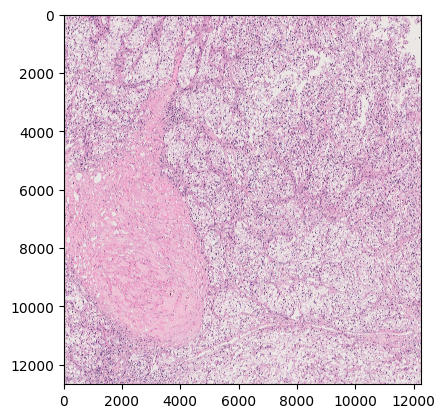

In [58]:
# Load ROI and get the Image. 
roi_name = r"roi_2_3"
patch_size = (512, 512)
overlap = 0 # number of pixel overlap
img_ext = "tif"
roi_x1, roi_y1, roi_x2, roi_y2, width, height = load_roi(os.path.join(ndpi_file_root, 'train_test_patches', roi_name + ".txt"))
save_patch_metadata_txt(ndpi_filename, roi_name, patch_size, overlap, img_ext, roi_x1, roi_y1, roi_x2, roi_y2, width, height, output_path=os.path.join(ndpi_file_root, 'train_test_patches', f"{roi_name}_patch_metadata.txt"))
image_roi = wsi.read_region([roi_x1,roi_y1], 0, [width,height])
image_roi = image_roi.convert('RGB')
image_roi = np.array(image_roi)
print(np.shape(image_roi))
# rescale H&E Image.
rescaled_image_roi = cv.resize(image_roi, None, fx=scale_factor_x, fy=scale_factor_y, interpolation=cv.INTER_CUBIC)
plt.imshow(rescaled_image_roi)
print(np.shape(rescaled_image_roi))
rescaled_image_roi = Image.fromarray(rescaled_image_roi)


split_image_into_patches(rescaled_image_roi, patch_size, overlap, os.path.join(ndpi_file_root, 'train_test_patches'), handle=roi_name, extension=img_ext)

In [ ]:
x0 = 100
y0 = 100
output_folder = r"E:\MUSE_BIT_Human_Tissue_data\20250701_kidney_JH69436370\normal\FFPE-HE"
patch_filename = r"example_rescaled_to_BIT.png"

rescaled_image_roi_crop = rescaled_image_roi.crop((x0, y0, x0+1985, y0+1789))
rescaled_image_roi_crop.save(os.path.join(output_folder, patch_filename))

### Split Test and Train

In [3]:
import os
import random
import shutil
from glob import glob

def split_images_train_test(source_folder, output_root, train_ratio=0.99, seed=42):
    """
    Randomly splits .tif images in source_folder into train and test folders.

    Args:
        source_folder (str): Path to folder containing .tif images.
        output_root (str): Root folder where 'train/' and 'test/' will be created.
        train_ratio (float): Ratio of images to put in train set.
        seed (int): Random seed for reproducibility.
    """
    os.makedirs(os.path.join(output_root, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_root, 'test'), exist_ok=True)

    tif_images = glob(os.path.join(source_folder, "*.tif"))
    random.seed(seed)
    random.shuffle(tif_images)

    split_index = int(len(tif_images) * train_ratio)
    train_images = tif_images[:split_index]
    test_images = tif_images[split_index:]

    print(f"Total images: {len(tif_images)}")
    print(f"Train: {len(train_images)}")
    print(f"Test: {len(test_images)}")

    for img_path in train_images:
        shutil.copy(img_path, os.path.join(output_root, 'train', os.path.basename(img_path)))

    for img_path in test_images:
        shutil.copy(img_path, os.path.join(output_root, 'test', os.path.basename(img_path)))

# Example usage:
# split_images_train_test("/path/to/images", "/path/to/split_output")


In [ ]:
ndpi_file_root = rf'C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\tumor\FFPE-HE'
test_train_folder = os.path.join(ndpi_file_root, 'train_test_patches')
split_images_train_test(test_train_folder, test_train_folder, train_ratio=0.99, seed=42)

Total images: 10276
Train: 10173
Test: 103


: 